In [1]:
import sys
import os.path as path

from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from skimage import color, io


C:\Users\Sasha\AppData\Local\Temp\ipykernel_4112\1475689872.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from alive_progress import alive_bar
import time

In [ ]:
with alive_bar(120000, force_tty=True) as bar:
    bar(60000, skipped=True)
    for i in range(60000, 120000):
        # process item
        time.sleep(0.2)
        bar()

|██████████████████████████▏             | ▄▆█ 78420/120000 [65%] in 1:01:41 (~2

In [ ]:



class DoubleConv(nn.Sequential):
    """(convolution => [BN] => LeakyReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, kernel_size=3, padding=1, bias=True):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        super().__init__(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=padding, bias=bias),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )


class Down(nn.Sequential):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        super().__init__(
            nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1),  # nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(self.n_channels, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        self.bottleneck1 = DoubleConv(512, 512)
        self.bottleneck2 = DoubleConv(512, 512)

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        bottleneck1 = self.bottleneck1(x4)
        bottleneck1_t = bottleneck1 + x4
        bottleneck2 = self.bottleneck2(bottleneck1_t)
        bottleneck2_t = bottleneck2 + bottleneck1 + x4

        x = self.up1(bottleneck2_t, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

class Descriptor(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels

        self.inc = DoubleConv(self.n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down3 = DoubleConv(512, 512)
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.Sigmoid(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.out(x)
        return x

In [3]:
DATA_PATH = r"D:\Projects\res\gray2color"

In [4]:
to_resize = transforms.Resize((128, 128))
to_tensor = transforms.ToTensor()

def tensor_transform(*args):
    result = []
    for image in args:
        image = to_tensor(image).float()
        image = to_resize(image)
        result.append(image)
    return result

dataset = ColorDataset(
    DATA_PATH,
    transform=tensor_transform
)

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=8,
                                          shuffle=True)

In [23]:
model = UNet(1, 2)
model = torch.load('generator.pt').eval()

In [24]:
import cv2

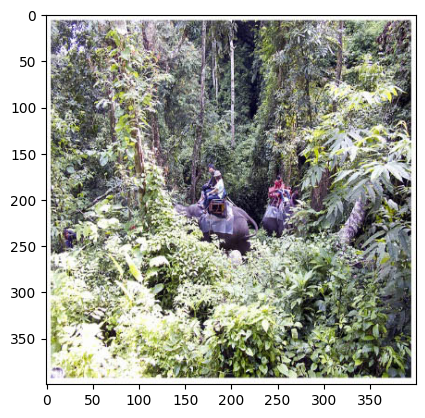

In [39]:
imagepath = dataset.dataframe.iloc[7]['color']
plt.imshow(plt.imread(imagepath))

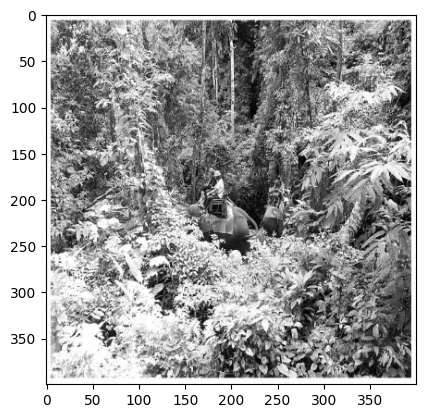

In [40]:
plt.imshow(color.rgb2gray(plt.imread(imagepath)), cmap='gray')

In [41]:
image = io.imread(imagepath)
lab_image = color.rgb2lab(image)
gray = lab_image[:, :, 0] / 100
colored = lab_image[:, :, 1:] / 128

In [42]:
x = tensor_transform(gray)[0]

In [43]:
t = torch.unsqueeze(x, 0)
p = model(t)[0]

In [44]:
p = p.detach().numpy()

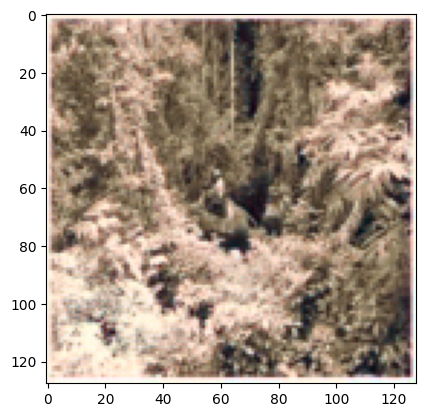

In [45]:
cur = np.zeros((128, 128, 3), dtype=float)
cur[:,:, 0] = x * 100
cur[:,:, 1] = p[0] * 128
cur[:,:, 2] = p[1] * 128
plt.imshow(color.lab2rgb(cur))

In [22]:
for i, item in enumerate(image):   
    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])
 
for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

ValueError: cannot reshape array of size 1200 into shape (28,28)